In [1]:
from src import database
import pandas as pd
from src import config

database.create_all()
database.models.Meta.insert(
    pd.read_excel(
        config.DATABASE_EXC, 
        sheet_name="tb_meta", 
        parse_dates=["inception_date"]
    )
)


In [6]:
from src import database as db

# with db.engine.connect() as conn:
    
#     conn.execute(
#         f"CREATE VIEW tb_test AS SELECT * FROM tb_meta WHERE tb_meta.meta_type == 'Equity'"
#     )


with db.SessionContext() as session:
    
    result = session.execute("SELECT * FROM tb_test")
    
    print(result.fetchall())


[('2023-05-04 03:50:59', '2023-05-04 03:50:59', None, 1, '069500', 'Equity', 'ETF', 'KR7069500007', '2002-10-14', 'KODEX 200', None, 0, '069500.KS', '069500', '069500 KS Equity', None, None), ('2023-05-04 03:50:59', '2023-05-04 03:50:59', None, 2, '069660', 'Equity', 'ETF', 'KR7069660009', '2002-10-14', 'KOSEF 200', None, 0, '069660.KS', '069660', '069660 KS Equity', None, None), ('2023-05-04 03:50:59', '2023-05-04 03:50:59', None, 3, '091230', 'Equity', 'ETF', 'KR7091230003', '2006-06-27', 'TIGER 반도체', None, 0, '091230.KS', '091230', '091230 KS Equity', None, None), ('2023-05-04 03:50:59', '2023-05-04 03:50:59', None, 4, '091220', 'Equity', 'ETF', 'KR7091220004', '2006-06-27', 'TIGER 은행', None, 0, '091220.KS', '091220', '091220 KS Equity', None, None), ('2023-05-04 03:50:59', '2023-05-04 03:50:59', None, 5, '091160', 'Equity', 'ETF', 'KR7091160002', '2006-06-27', 'KODEX 반도체', None, 0, '091160.KS', '091160', '091160 KS Equity', None, None), ('2023-05-04 03:50:59', '2023-05-04 03:50:59'

[*********************100%***********************]  6 of 6 completed
simulate |██████████████████████████████████████████████████| 100.00% 6378.99


<AxesSubplot:>

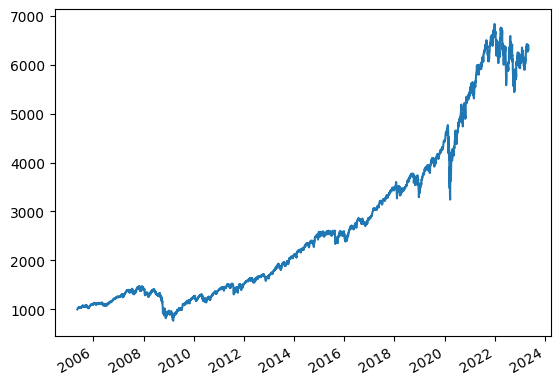

In [10]:
from src.core.strategies import HierarchicalEqualRiskContribution
import yfinance as yf

prices = yf.download("SPY, QQQ, XLG, XLV, XLU, XLB")["Adj Close"]

strategy = HierarchicalEqualRiskContribution(prices=prices.dropna()).simulate()

strategy.value.plot()

[*********************100%***********************]  6 of 6 completed
simulate |██████████████████████████████████████████████████| 99.20% 2023-05-05 00:00:00 - 1548.23

<AxesSubplot:>

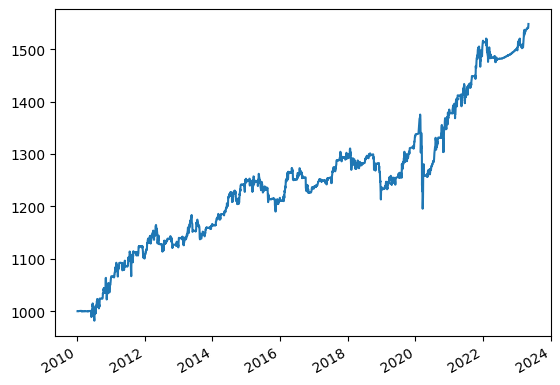

In [5]:
from typing import Optional
import pandas as pd
from src.core.strategies import Strategy
from src.core.analytics.features import momentum
from src.core.analytics.metrics import to_ann_volatility


class DualMomentum(Strategy):
    # Objective: balanced growth
    # Type: momentum strategy
    # Invests in: ETFs tracking stocks, bonds, real estate, and gold
    # Rebalancing schedule: monthly
    # Taxation: 50% short-term capital gains
    # Minimum account size: $5,000

    def rebalance(self) -> Optional[pd.Series]:
        safe = to_ann_volatility(self.reb_prices.iloc[-252:]).idxmin()
        mome_1y = momentum(self.reb_prices, months=6).iloc[-1]
        safe_mome = mome_1y.loc[safe]
        weights = {}
        for asset in self.reb_prices:
            if asset == safe:
                continue
            if mome_1y.loc[asset] > safe_mome:
                weights.update({asset: 0.20})
            else:
                if safe in weights.keys():
                    weights.update({safe: weights[safe] + 0.20})
                else:
                    weights.update({safe: 0.20})
        return pd.Series(weights)


import yfinance as yf

prices = yf.download("SPY, BND, VNQ, VCSH, GLD, BIL")["Adj Close"].dropna()

strategy = DualMomentum(prices=prices).simulate(start="2010-1-1")

strategy.value.plot()


<AxesSubplot:>

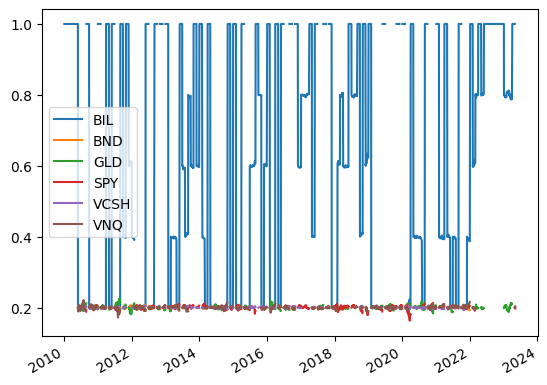

In [7]:
strategy.weights.plot()

In [2]:
from src.core.strategies import HierarchicalEqualRiskContribution
import yfinance as yf

prices = yf.download("SPY, AGG, GSG, TLT")["Adj Close"]

strategy = HierarchicalEqualRiskContribution(prices=prices.dropna()).simulate()

strategy.value


[*********************100%***********************]  4 of 4 completed
simulate |--------------------------------------------------| 0.02% 1000.00

ValueError: Distance matrix 'X' must be symmetric.

In [2]:
from src import database as db

with db.SessionContext() as session:

    for (source,) in session.query(db.models.Meta.source).distinct():

        print(source)
        if source == "YAHOO":
            import yfinance as yf
            for meta in (
                session.query(db.models.Meta).filter(db.models.Meta.source == source).all()
            ):
                data = yf.download(
                    tickers=meta.code, start="1980-1-1", progress=False, actions=True
                ).reset_index()
                data.columns = data.columns.str.lower()
                data.columns = data.columns.str.replace(" ", "_")
                data["pri_return"] = (
                    data.close.divide(data.close.shift(1)).subtract(1).fillna(0)
                )
                if "dividends" in data.columns:
                    data["dvd_return"] = (
                        data.dividends.divide(data.close.shift(1)).fillna(0)
                    )
                else:
                    data["dvd_return"] = 0
                data["tot_return"] = data["pri_return"].add(data["dvd_return"])
                data = data.assign(meta_id=meta.meta_id)
                print(data)

        elif source == "NAVER":
            import pandas_datareader as pdr
            for meta in (
                session.query(db.models.Meta).filter(db.models.Meta.source == source).all()
            ):
                data = pdr.DataReader(name=meta.code, data_source="naver", start="1980-1-1").astype(float)
                data = data.reset_index()
                data.columns = data.columns.str.lower()
                data.columns = data.columns.str.replace(" ", "_")
                data["pri_return"] = (
                    data.close.divide(data.close.shift(1)).subtract(1).fillna(0)
                )
                if "dividends" in data.columns:
                    data["dvd_return"] = (
                        data.dividends.divide(data.close.shift(1)).fillna(0)
                    )
                else:
                    data["dvd_return"] = 0
                data["tot_return"] = data["pri_return"].add(data["dvd_return"])
                data = data.assign(meta_id=meta.meta_id)
                print(data)
        else:
            data = None
        



NAVER
           date     open     high      low    close     volume  pri_return  \
0    2002-10-14   5315.0   5450.0   5169.0   5296.0  3770562.0    0.000000   
1    2002-10-15   5350.0   5436.0   5247.0   5428.0  3348530.0    0.024924   
2    2002-10-16   5479.0   5479.0   5388.0   5451.0  2983330.0    0.004237   
3    2002-10-17   5436.0   5576.0   5363.0   5525.0  3060329.0    0.013575   
4    2002-10-18   5658.0   5793.0   5622.0   5760.0  1933100.0    0.042534   
...         ...      ...      ...      ...      ...        ...         ...   
5081 2023-04-27  32470.0  32580.0  32160.0  32560.0  6525733.0    0.003390   
5082 2023-04-28  32735.0  32895.0  32490.0  32625.0  9407032.0    0.001996   
5083 2023-05-02  32720.0  32980.0  32675.0  32980.0  6646106.0    0.010881   
5084 2023-05-03  32725.0  32820.0  32620.0  32685.0  6572422.0   -0.008945   
5085 2023-05-04  32555.0  32650.0  32455.0  32560.0  2595615.0   -0.003824   

      dvd_return  tot_return  meta_id  
0              0 

In [ ]:
import pandas as pd

w = pd.read_clipboard(index_col="date")
r = w.stack().astype(float)
r = r.reset_index()
r.columns = ["date", "ticker", "weight"]
r = r[r.weight != 0.0]
r.to_clipboard()

In [ ]:
pd.to_datetime(pd.to_datetime("2022-2-1")).to_pydatetime()

In [ ]:
pd.read_excel(
    config.DATABASE_EXC, 
    sheet_name="tb_meta", 
    parse_dates=["inception_date"]
).sort_values("meta_id")

In [ ]:
import pandas_datareader as pdr
import pandas as pd
def leading_economic_indicator() -> pd.DataFrame:
    """
    Get raw data for leading economic indicator regime.
    """
    tickers = dict(USALOLITONOSTSAM="USLEI")
    data = pdr.DataReader(list(tickers.keys()), "fred", start="1900-01-01").resample("M").last()
    data = data.rename(columns=tickers)
    return data[['USLEI']]

leading_economic_indicator()

In [ ]:
from src.core import metrics


import pandas as pd
nav = pd.read_clipboard(index_col="date", parse_dates=True)
nav

In [ ]:
metrics.to_max_drawdown(nav).to_clipboard()

In [ ]:
(prices / prices.resample("D").last().ffill().shift(1, freq=pd.DateOffset(months=1))).dropna()


In [ ]:
prices.pct_change(21)

In [ ]:
import pandas as pd

pri_returns = prices.pct_change()
latest_date = pri_returns.index[-1]
start_date = latest_date + pd.DateOffset(years=5)
start_date

In [ ]:
from src import db


db.create_all()

In [ ]:
import pandas as pd

pr_date = prices.index[-1] - pd.DateOffset(years = 1)

prices.iloc[-1] / prices.iloc[prices.index.get_loc(pr_date)] - 1

In [ ]:
import pandas_datareader as pdr



price = pdr.DataReader("329200", "naver", start="2021-4-1")
price.to_csv("329200.csv")

In [ ]:
import json

import pandas as pd
from sec_api import QueryApi
from sec_api import ExtractorApi
from src.config import EDGAR_API

queryApi = QueryApi(api_key=EDGAR_API)

query = {
    "query": {
        "query_string": {
            "query": "ticker:TSLA",
        }
    },
    "from": "200",
    "size": "300",
    "sort": [{"filedAt": {"order": "desc"}}],
}

response = queryApi.get_filings(query)


metadata = pd.DataFrame.from_records(response["filings"])

print(metadata)


# extractorApi = ExtractorApi(EDGAR_API)


# sections_10_k = {
#     "1": "Business",
#     "1A": "Risk Factors",
#     "1B": "Unresolved Staff Comments",
#     "2": "Properties",
#     "3": "Legal Proceedings",
#     "4": "Mine Safety Disclosures",
#     "5": "Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities",
#     "6": "Selected Financial Data (prior to February 2021)",
#     "7": "Management’s Discussion and Analysis of Financial Condition and Results of Operations",
#     "7A": "Quantitative and Qualitative Disclosures about Market Risk",
#     "8": "Financial Statements and Supplementary Data",
#     "9": "Changes in and Disagreements with Accountants on Accounting and Financial Disclosure",
#     "9A": "Controls and Procedures",
#     "9B": "Other Information",
#     "10": "Directors, Executive Officers and Corporate Governance",
#     "11": "Executive Compensation",
#     "12": "Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters",
#     "13": "Certain Relationships and Related Transactions, and Director Independence",
#     "14": "Principal Accountant Fees and Services",
# }


# for id, f in enumerate(response["filings"]):
#     if f["formType"] == "10-K":
#         url_10k = f["linkToFilingDetails"]

#         out = {}

#         for sec, des in sections_10_k.items():
#             out[des] = extractorApi.get_section(url_10k, sec, "text")

#         filename = f"{id}.json"

#         with open(filename, "w") as f:
#             json.dump(out, f)


In [ ]:
metadata.to_csv(
    'test.csv'
)

In [ ]:
response['filings'][0]['linkToTxt']

In [ ]:


# 8-K example
url_8k = "https://www.sec.gov/Archives/edgar/data/66600/000149315222016468/form8-k.htm"

item_1_1_text = extractorApi.get_section(response['filings'][0]['linkToTxt'], "1-1", "text")
item_1_1_text

In [ ]:


stra = strategy.HierarchicalEqualRiskContribution(prices=prices).simulate(
    start="2015-1-1"
)
stra.value.plot()
# weights_bm = prices.notna().divide(prices.notna().sum(axis=1), axis=0)
# metrics.to_pri_return(prices=prices).multiply(weights_bm).sum(axis=1).loc["2015-1-1":].add(1).cumprod().multiply(1000).plot()
stra.analytics()

In [ ]:
from src import db


with db.SessionContext() as session:
    
    query = session.query(db.models.Meta)
    
    result = list(record.to_dict() for record in query.all())
    
print(result)

In [ ]:
import pandas as pd

pd.DataFrame(result)

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# create line chart trace
line_trace = go.Scatter(
    x=stra.value.index, y=stra.value.values, mode="lines", name=stra.value.name
)

# create stacked bar chart traces
bar_traces = []
for col in stra.allocations.columns:
    trace = go.Bar(x=stra.allocations.index, y=stra.allocations[col]*100, name=col)
    bar_traces.append(trace)

# create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# add line chart to the first subplot with its own legend
fig.add_trace(line_trace, row=1, col=1)
fig.update_traces(showlegend=True, row=1, col=1)

# add stacked bar chart to the second subplot with its own legend
for trace in bar_traces:
    fig.add_trace(trace, row=2, col=1)
    fig.update_traces(showlegend=True, row=2, col=1)

# update chart layout and style
fig.update_layout(
    title="My Beautiful Subplots",
    xaxis_title="Date",
    yaxis_title="Values",
    template="plotly_dark",
    hovermode="x unified",
    showlegend=True,
    legend=dict(
        x=0.5,
        y=1.2,
        orientation='h',
        xanchor='center',
        yanchor='bottom',
        bordercolor="white",
        borderwidth=1,
        bgcolor="white",
        font=dict(size=12),
    ),
    font=dict(family="Arial", size=12, color="black"),
    barmode="stack",
    # add legends for subplots
    annotations=[
        dict(
            x=0.5,
            y=1.1,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<b>Line Chart</b>",
            font=dict(size=14),
            align="center",
        ),
        dict(
            x=0.5,
            y=0.6,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<b>Stacked Bar Chart</b>",
            font=dict(size=14),
            align="center",
        ),
    ],
)

# show the chart
fig.show()


In [1]:
from src.core.portfolios import Optimizer
import yfinance as yf

prices = yf.download("SPY, AGG, GSG, TLT")["Adj Close"]
opt = Optimizer.from_prices(prices=prices)
opt.hierarchical_equal_risk_contribution()

[*********************100%***********************]  4 of 4 completed


AGG    0.304066
GSG    0.156254
SPY    0.187852
TLT    0.351828
Name: weights, dtype: float64

In [7]:
opt.hierarchical_risk_parity()

AGG    0.306069
GSG    0.146633
SPY    0.199220
TLT    0.348077
Name: weights, dtype: float64

In [4]:
opt.maximized_sharpe_ratio()

AGG    0.637770
GSG   -0.000000
SPY    0.238703
TLT    0.123527
Name: weights, dtype: float64